## Intro to using StatsBomb data for match analysis

In [83]:
pip install statsbombpy

Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.


### Import the event data 

In [84]:
pip install --upgrade pip

Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.


In [85]:
pip install matplotlib --upgrade

Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.


In [86]:
pip install mplsoccer

Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.


In [87]:
from statsbombpy import sb
import pandas as pd
from pandas import json_normalize
import numpy as np

import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import matplotlib.patheffects as path_effects

# We'll only use a vertical pitch for this tutorial
from mplsoccer import VerticalPitch, Sbopen

# Get competitions
comp = sb.competitions()
comp.to_csv('competitions.csv', index=False)



In [88]:
# Get Matches from 2022 FIFA World Cup
df = sb.matches(competition_id=43, season_id=106)
df.to_csv('CSVs/WC_Matches.csv', index=False)

,match_id,match_date,kick_off,competition,season,home_team,away_team,home_score,away_score,match_status,...,last_updated_360,match_week,competition_stage,stadium,referee,home_managers,away_managers,data_version,shot_fidelity_version,xy_fidelity_version
0,3869254,2022-12-06,21:00:00.000,International - FIFA World Cup,2022,Portugal,Switzerland,6,1,available,...,2023-01-14T15:08:46.172894,4,Round of 16,Lusail Stadium,César Arturo Ramos Palazuelos,Fernando Manuel Fernandes da Costa Santos,Murat Yakin,1.1.0,2,2
1,3869118,2022-12-04,21:00:00.000,International - FIFA World Cup,2022,England,Senegal,3,0,available,...,2022-12-13T21:39:52.223504,4,Round of 16,Al Bayt Stadium,Ivan Arcides Barton Cisneros,Gareth Southgate,Aliou Cissé,1.1.0,2,2
2,3869486,2022-12-10,17:00:00.000,International - FIFA World Cup,2022,Morocco,Portugal,1,0,available,...,2023-01-04T12:36:10.102347,5,Quarter-finals,Al Thumama Stadium,Facundo Tello Figueroa,Hoalid Regragui,Fernando Manuel Fernandes da Costa Santos,1.1.0,2,2
3,3869685,2022-12-18,17:00:00.000,International - FIFA World Cup,2022,Argentina,France,3,3,available,...,2022-12-21T16:02:21.075183,7,Final,Lusail Stadium,Szymon Marciniak,Lionel Sebastián Scaloni,Didier Deschamps,1.1.0,2,2
4,3869684,2022-12-17,17:00:00.000,International - FIFA World Cup,2022,Croatia,Morocco,2,1,available,...,2022-12-18T21:30:47.341680,7,3rd Place Final,Sheikh Khalifa International Stadium,Abdulrahman Ibrahim Al Jassim,Zlatko Dalić,Hoalid Regragui,1.1.0,2,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
59,3857260,2022-11-30,21:00:00.000,International - FIFA World Cup,2022,Saudi Arabia,Mexico,1,2,available,...,2022-12-01T19:56:40.363859,3,Group Stage,Lusail Stadium,Michael Oliver,Hervé Renard,Gerardo Daniel Martino,1.1.0,2,2
60,3857258,2022-11-24,21:00:00.000,International - FIFA World Cup,2022,Brazil,Serbia,2,0,available,...,2022-12-06T17:57:00.355945,1,Group Stage,Lusail Stadium,Alireza Faghani,Telê Santana da Silva,Dragan Stojković,1.1.0,2,2
61,3857257,2022-11-30,17:00:00.000,International - FIFA World Cup,2022,Australia,Denmark,1,0,available,...,2022-12-21T16:01:27.541055,3,Group Stage,Al Janoub Stadium,Mustapha Ghorbal,Graham James Arnold,Kasper Hjulmand,1.1.0,2,2
62,3857255,2022-12-01,21:00:00.000,International - FIFA World Cup,2022,Japan,Spain,2,1,available,...,2022-12-21T15:58:42.193326,3,Group Stage,Sheikh Khalifa International Stadium,Victor Miguel de Freitas Gomes,Hajime Moriyasu,Luis Enrique Martínez García,1.1.0,2,2


In [116]:

# Find a match_id required
match = 3869118
match_events = sb.events(match_id=match)
team_list = list(match_events.team.unique())

In [114]:
def create_passmap_df(national_team:str,match_events:pd.DataFrame):
    
    first_half = match_events.loc[match_events['period'] == 1] 
    second_half = match_events.loc[match_events['period'] == 2]
    pass_raw = first_half[match_events.type== 'Pass']
    pass_number_raw = pass_raw[['timestamp', 'player', 'pass_recipient']]
    pass_number_raw['pair'] = pass_number_raw.player + pass_number_raw.pass_recipient
    pass_count = pass_number_raw.groupby(['pair']).count().reset_index()
    pass_count = pass_count[['pair', 'timestamp']]
    pass_count.columns = ['pair', 'number_pass']

    avg_loc_df = pass_raw[['team', 'player', 'location']]
    avg_loc_df['pos_x'] = avg_loc_df.location.apply(lambda x: x[0])
    avg_loc_df['pos_y'] = avg_loc_df.location.apply(lambda x: x[1])
    avg_loc_df = avg_loc_df.drop('location', axis=1)

    avg_loc_df = avg_loc_df.groupby(['team','player']).agg({'pos_x': np.mean, 'pos_y': np.mean}).reset_index()

    pass_merge = pass_number_raw.merge(pass_count, on='pair')
    pass_merge = pass_merge[['player', 'pass_recipient', 'number_pass']]
    pass_merge = pass_merge.drop_duplicates()

    avg_loc_df = avg_loc_df[['player', 'pos_x', 'pos_y']]

    pass_cleaned = pass_merge.merge(avg_loc_df, on='player')
    pass_cleaned.rename({'pos_x': 'pos_x_start', 'pos_y': 'pos_y_start'}, axis='columns', inplace=True)

    pass_cleaned = pass_cleaned.merge(avg_loc_df, left_on='pass_recipient', right_on='player', suffixes=['', '_end'])
    pass_cleaned.rename({'pos_x': 'pos_x_end', 'pos_y': 'pos_y_end'}, axis='columns', inplace=True)

    # pass_cleaned = pass_cleaned.drop(['player_name_end'], axis=1)

    player_df = first_half[first_half.team == national_team ].groupby('player').agg({'minute': [min, max]}).reset_index()
    player_df = pd.concat([player_df['player'], player_df['minute']], axis=1)
    player_df['minutes_played'] = player_df['max'] - player_df['min']
    player_df = player_df.sort_values('minutes_played', ascending=False)

    player_names = player_df.player[:11].tolist()

    pass_team = pass_cleaned[pass_cleaned.player.isin(player_names)]
    pass_team = pass_team[pass_team.pass_recipient.isin(player_names)]

    pass_team['width'] = pass_team['number_pass'] / pass_team['number_pass'].max()

    return pass_team



In [115]:
pass_df = create_passmap_df("England",match_events)

/var/folders/6h/6k3qgyf57t36w9tvygh1x2wc0000gn/T/ipykernel_23234/355182805.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pass_number_raw['pair'] = pass_number_raw.player + pass_number_raw.pass_recipient
/var/folders/6h/6k3qgyf57t36w9tvygh1x2wc0000gn/T/ipykernel_23234/355182805.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  avg_loc_df['pos_x'] = avg_loc_df.location.apply(lambda x: x[0])
/var/folders/6h/6k3qgyf57t36w9tvygh1x2wc0000gn/T/ipykernel_23234/355182805.py:14: SettingWithCopyWarning: 
A va

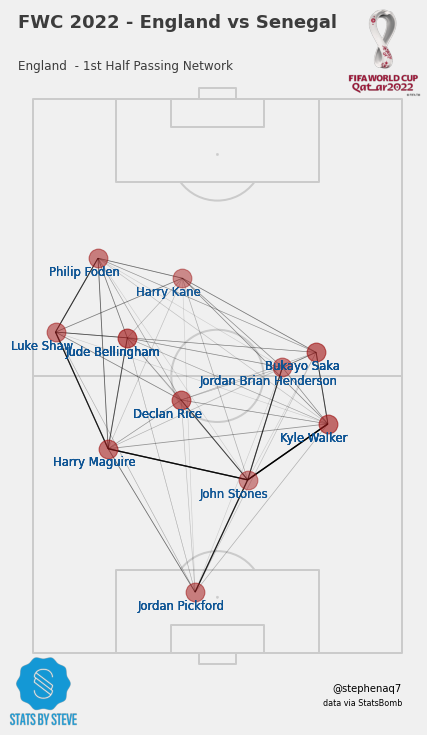

In [180]:
from matplotlib.colors import to_rgba
import matplotlib.style as style
from PIL import Image
import matplotlib.image as image


style.use('fivethirtyeight')

MIN_TRANSPARENCY = 0.1
color = np.array(to_rgba('black'))
color = np.tile(color, (len(pass_df), 1))
c_transparency = pass_df.number_pass / pass_df.number_pass.max()
c_transparency = (c_transparency * (1 - MIN_TRANSPARENCY)) + MIN_TRANSPARENCY
color[:, 3] = c_transparency

pitch = VerticalPitch(pitch_type='statsbomb', 
    half = False,
    axis = True, 
    # label = True, 
    # tick = True,
    goal_type='box')
    
fig, axs = pitch.grid(figheight=10, title_height=0.08, endnote_space=0, axis=False, 
                      title_space=0, grid_height=0.82, endnote_height=0.05)


pass_lines = pitch.lines(pass_df.pos_x_start, pass_df.pos_y_start,
                         pass_df.pos_x_end, pass_df.pos_y_end, 
                         lw=pass_df.width+0.5,
                         color=color, zorder=1, ax=axs['pitch'])

pass_nodes = pitch.scatter(pass_df.pos_x_start, pass_df.pos_y_start, s=350,
                           color= '#a71c1c', linewidth=1, alpha=0.1, ax=axs['pitch'])

for index, row in pass_df.iterrows():
    pitch.annotate(row.player, xy=(row.pos_x_start-3, row.pos_y_start-3), c='#0b5394', va='center',
                   ha='center', size='small', weight = 'light', family='sans-serif', ax=axs['pitch'],stretch= 'ultra-condensed',style="normal" ,alpha=0.5)
    
# endnote /title
axs['endnote'].text(1, 0.5, '@stephenaq7',
                    va='center', ha='right', fontsize=10)
axs['endnote'].text(1, 0.1, 'data via StatsBomb',
                    va='center', ha='right', fontsize=8)

### Add Fifa WC logo
ax2 = fig.add_axes([0.8, 0.035, 0.175, 1.8])
ax2.axis('off')
img = image.imread('/Users/stephenahiabah/code/statsbomb_project/FWC_Logo.png')
ax2.imshow(img)


### Add Stats by Steve logo
ax3 = fig.add_axes([0.008, -0.028, 0.17, 0.15])
ax3.axis('off')
img = image.imread('/Users/stephenahiabah/code/statsbomb_project/logo_transparent_background.png')
ax3.imshow(img)

axs['title'].text(0.4, 1, f'FWC 2022 - {team_list[0]} vs {team_list[1]} ', weight = 'bold', alpha = .75,
                  va='center', ha='center', fontsize=18)
axs['title'].text(0.25, 0.25, f'{team_list[0]}  - 1st Half Passing Network',
                  va='center', ha='center', alpha = .75, fontsize=12)
plt.savefig(f'Output Visuals/{team_list[0]} - Passing Networks.png', dpi=300, bbox_inches='tight')
plt.show()

In [106]:
shot_raw = match_events[match_events.type== 'Shot']
shot_raw["location"] = shot_raw["location"].astype(str)
shot_raw["location"] = shot_raw["location"].str[1:]
shot_raw["location"] = shot_raw["location"].str[:-1]
shot_raw[["location"]]
shot_raw[["x", "y"]] = shot_raw["location"].str.split(",", expand=True).astype(np.float32)

/var/folders/6h/6k3qgyf57t36w9tvygh1x2wc0000gn/T/ipykernel_23234/2117207732.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  shot_raw["location"] = shot_raw["location"].astype(str)
/var/folders/6h/6k3qgyf57t36w9tvygh1x2wc0000gn/T/ipykernel_23234/2117207732.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  shot_raw["location"] = shot_raw["location"].str[1:]
/var/folders/6h/6k3qgyf57t36w9tvygh1x2wc0000gn/T/ipykernel_23234/2117207732.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of 

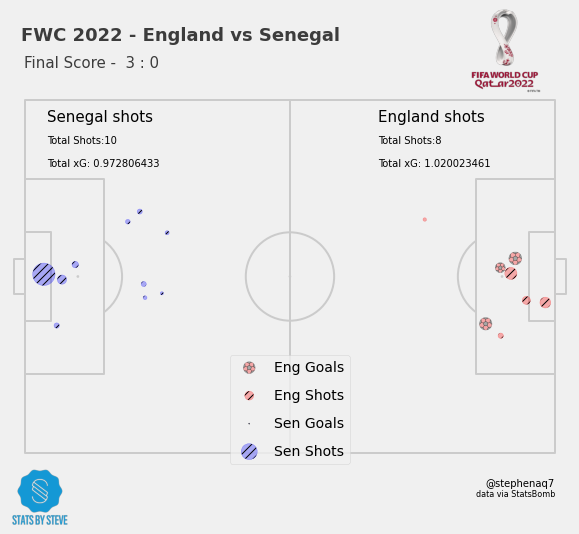

In [237]:
import seaborn as sns
from mplsoccer import Pitch

def generateTeamxGDataFrame(team):
    xg = shot_raw[['team','minute','type','shot_statsbomb_xg','x','y',"shot_outcome"]]
    team_xg = xg[xg['team']==team].reset_index()
    return team_xg
    

def generateCombinedShotMap(team1,team2):
    team1_xg = generateTeamxGDataFrame(team1)
    team2_xg = generateTeamxGDataFrame(team2)
    team1_shots = team1_xg[team1_xg.type=='Shot']

    team1_goals = team1_shots[team1_shots.shot_outcome == 'Goal'].copy()
    team1_non_goals = team1_shots[team1_shots.shot_outcome != 'Goal'].copy()

    team2_shots = team2_xg[team2_xg.type=='Shot']

    team2_goals = team2_shots[team2_shots.shot_outcome == 'Goal'].copy()
    team2_non_goals = team2_shots[team2_shots.shot_outcome != 'Goal'].copy()

    pitch = Pitch(pitch_type='statsbomb', 
    half = False,
    axis = True, 
    # label = True, 
    # tick = True,
    goal_type='box')
    fig, ax = pitch.grid(grid_height=0.6, title_height=0.06, axis=False,endnote_height=0.04, title_space=0, endnote_space=0)

# team 1 shots and goals
    pitch.scatter(team1_goals.x, team1_goals.y, alpha = 0.3, s = team1_goals.shot_statsbomb_xg*800, c = "red", ax=ax['pitch'], marker='football',label="Eng Goals")
    pitch.scatter(team1_non_goals.x, team1_non_goals.y, alpha = 0.3, s = team1_non_goals.shot_statsbomb_xg*800, c = "red", ax=ax['pitch'],hatch='///',label="Eng Shots")

# team 2 shots and goals

    pitch.scatter(120-team2_goals.x, 80-team2_goals.y, alpha = 0.3, s = team2_goals.shot_statsbomb_xg*800, c = "blue", ax=ax['pitch'], marker='football',label="Sen Goals")
    pitch.scatter(120-team2_non_goals.x, 80-team2_non_goals.y, alpha = 0.3, s = team2_non_goals.shot_statsbomb_xg*800, c = "blue", hatch='///', ax=ax['pitch'],label="Sen Shots")


    ax['pitch'].text(5, 5, team2 + ' shots',size=15)
    ax['pitch'].text(5, 10, f'Total Shots:' + str(len(team2_xg)),size=10)
    ax['pitch'].text(5, 15, f'Total xG: ' + str((team2_xg.shot_statsbomb_xg.sum())),size=10)
    ax['pitch'].text(80, 5, team1 + ' shots',size=15)
    ax['pitch'].text(80, 10, f'Total Shots:' + str(len(team1_xg)),size=10)
    ax['pitch'].text(80, 15, f'Total xG: ' + str(team1_xg.shot_statsbomb_xg.sum()),size=10)

 
                           
    ax['pitch'].legend(labelspacing=1, loc="lower center")

### Add Fifa WC logo
    ax2 = fig.add_axes([0.8, 0.04, 0.12, 1.6])
    ax2.axis('off')
    img = image.imread('/Users/stephenahiabah/code/statsbomb_project/FWC_Logo.png')
    ax2.imshow(img)


    ### Add Stats by Steve logo
    ax3 = fig.add_axes([0.03, 0.1, 0.1, 0.1])
    ax3.axis('off')
    img = image.imread('/Users/stephenahiabah/code/statsbomb_project/logo_transparent_background.png')
    ax3.imshow(img)

    ax['title'].text(0.3, 1.2, f'FWC 2022 - {team_list[0]} vs {team_list[1]} ', weight = 'bold', alpha = .75,
                    va='center', ha='center', fontsize=18)
    ax['title'].text(0.13, 0.5, f'Final Score -  {str(len(team1_goals))} : {str(len(team2_goals))} ',  alpha = .75,
                va='center', ha='center', fontsize=15)
    
    # endnote /title    
    ax['endnote'].text(1, 0.5, '@stephenaq7',
                    va='center', ha='right', fontsize=10)
    ax['endnote'].text(1, 0.1, 'data via StatsBomb',
                    va='center', ha='right', fontsize=8)

 # calling the function
generateCombinedShotMap('England','Senegal')
